# Nanodegree Engenheiro de Machine Learning
## Projeto final
Marco Aurélio Moura Suriani<br>
23 de abril de 2019
***
# Previsão da necessidade de reforço escolar para alunos de matemática de acordo com características demogaficas, sociais e acadêmicas

In [1]:
# Importando funções e bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import copy
from time import time

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

class formating:
    bold = '\x1b[1m'
    resetbold = '\x1b[21m'

%matplotlib inline

O pacote de dados (_dataset_) pode ser encontrado na internet em link fornecido no README.

In [2]:
# Leitura do arquivo .csv com o dataset
mat_student_data = pd.read_csv('student-mat.csv', delimiter=';')

A seguir, uma breve visão geral sobre o _dataset_ e suas variáveis.

In [3]:
# Observação das 5 primeiras instâncias do dataset
print(mat_student_data.iloc[:,0:10].head(), end='')
print('  ... \n')
print(mat_student_data.iloc[:,10:18].head(), end='')
print('  ... \n')
print(mat_student_data.iloc[:,18:26].head(), end='')
print('  ... \n')
print(mat_student_data.iloc[:,26:34].head())

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob
0     GP   F   18       U     GT3       A     4     4  at_home   teacher
1     GP   F   17       U     GT3       T     1     1  at_home     other
2     GP   F   15       U     LE3       T     1     1  at_home     other
3     GP   F   15       U     GT3       T     4     2   health  services
4     GP   F   16       U     GT3       T     3     3    other     other  ... 

   reason guardian  traveltime  studytime  failures schoolsup famsup paid
0  course   mother           2          2         0       yes     no   no
1  course   father           1          2         0        no    yes   no
2   other   mother           1          2         3       yes     no  yes
3    home   mother           1          3         0        no    yes  yes
4    home   father           1          2         0        no    yes  yes  ... 

  activities nursery higher internet romantic  famrel  freetime  goout
0         no     yes    yes      

In [4]:
# Descrição estatística das variáveis numéricas/categóricas ordinais
print(mat_student_data.describe())

              age        Medu        Fedu  traveltime   studytime    failures  \
count  395.000000  395.000000  395.000000  395.000000  395.000000  395.000000   
mean    16.696203    2.749367    2.521519    1.448101    2.035443    0.334177   
std      1.276043    1.094735    1.088201    0.697505    0.839240    0.743651   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    2.000000    1.000000    1.000000    0.000000   
50%     17.000000    3.000000    2.000000    1.000000    2.000000    0.000000   
75%     18.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     22.000000    4.000000    4.000000    4.000000    4.000000    3.000000   

           famrel    freetime       goout        Dalc        Walc      health  \
count  395.000000  395.000000  395.000000  395.000000  395.000000  395.000000   
mean     3.944304    3.235443    3.108861    1.481013    2.291139    3.554430   
std      0.896659    0.9988

In [5]:
# Informações sobre todas as variáveis: nomes, instâncias e tipo de dado - parte 1
mat_student_data.iloc[:,:15].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 15 columns):
school        395 non-null object
sex           395 non-null object
age           395 non-null int64
address       395 non-null object
famsize       395 non-null object
Pstatus       395 non-null object
Medu          395 non-null int64
Fedu          395 non-null int64
Mjob          395 non-null object
Fjob          395 non-null object
reason        395 non-null object
guardian      395 non-null object
traveltime    395 non-null int64
studytime     395 non-null int64
failures      395 non-null int64
dtypes: int64(6), object(9)
memory usage: 46.4+ KB


In [6]:
# Informações sobre todas as variáveis: nomes, instâncias e tipo de dado - parte 2
mat_student_data.iloc[:,15:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 18 columns):
schoolsup     395 non-null object
famsup        395 non-null object
paid          395 non-null object
activities    395 non-null object
nursery       395 non-null object
higher        395 non-null object
internet      395 non-null object
romantic      395 non-null object
famrel        395 non-null int64
freetime      395 non-null int64
goout         395 non-null int64
Dalc          395 non-null int64
Walc          395 non-null int64
health        395 non-null int64
absences      395 non-null int64
G1            395 non-null int64
G2            395 non-null int64
G3            395 non-null int64
dtypes: int64(10), object(8)
memory usage: 55.6+ KB


Das 33 variáveis, pode-se observar que:
* 6 são numéricas discretas;
* 10 são categóricas ordinais (é importante ressaltar que tais variáveis são categóricas pois expressam avaliações pessoais, ao invés de intensidades; entretanto, por serem ordinais, elas podem ser expressas através de números discretos; no caso deste dataset, todas elas vieram expressas como números, poupando trabalho de pré-processamento de dados);
* 4 são categóricas nominais (por não haver hierarquia entre as categorias, não podem ser expressas através de números discretos; a solução mais comum é usar o método _one-hot encondig_);
* 13 são categóricas binárias (que podem ser expressas através de 0/1).

Em termos de entradas/saídas, pode-se observar que existem:
* 29 são variáveis de entrada (que podem ser conhecidas no início do ano);
* 4 são variáveis de saída (que só podem ser conhecidas no decorrer ou no fim do ano; as notas G1 e G2, em tese, podem funcionar como entradas, desde que se considere que o modelo será usado após G2. as faltas (_absences_) só podem aser conhecidas no fim do ano, e não podem aser usadas como entrada em nenhuma hipótese).

In [7]:
# Lista de variáveis segundo seu tipo
var_num_disc = ['age', 'failures', 'absences', 'G1', 'G2', 'G3']
var_cat_ordn = ['Medu', 'Fedu', 'traveltime', 'studytime', 'famrel', 'freetime', 'goout', 'Dalc', 
                'Walc', 'health']
var_cat_nmnl = ['Mjob', 'Fjob', 'reason', 'guardian']
var_cat_bnry = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 
                'activities', 'nursery', 'higher', 'internet', 'romantic']

var_input = ['age', 'failures', 'Medu', 'Fedu', 'traveltime', 'studytime', 'famrel', 'freetime', 
             'goout', 'Dalc', 'Walc', 'health', 'Mjob', 'Fjob', 'reason', 'guardian', 'school', 
             'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 
             'nursery', 'higher', 'internet', 'romantic']
var_output = ['absences', 'G1', 'G2', 'G3']

****
### Etapa 1: Pré-processamento de dados
A etapa de pré-processamento contém os seguintes passos:
* Criar uma cópia do dataset original que possa ser alterada livremente;
* Alterar a escala [(Rescale data)](https://www.geeksforgeeks.org/data-preprocessing-machine-learning-python/) das variáveias numéricas de entrada e das variáveis categóricas ordinais (que já estão expressas através de números discretos) para a escala \[0, 1\]. Desta forma, o menor valor de cada variável se torna 0, o maior se torna 1, e os demais valores são calculados proporcionalmente;
* Converter em números binários [(Binarize data)](https://www.geeksforgeeks.org/data-preprocessing-machine-learning-python/) as variáveis categóricas binárias. Uma das categorias será 0 e a outra será 1. Tal escolha é arbitrária e não influencia o resultado final;
* Codificar através do método one-hot [(One-hot encoding)](https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding) as variáveis categóricas nominais. Tal método cria variáveis _dummy_ do tipo binárias para cada categoria da variável original. Em seguida, as variáveis originais são apagadas.

Em seguida, são criadas as variáveis de atributos (_features_) e de alvos (_targets_):
* ___Atributos (X):___ Variáveis pré-processadas de entrada (excluem-se as saídas 'absences' e as notas 'G1 a 'G3');
* ___Alvo numérico (Y):___ Variável de saída (nota G3) expressa numericamente;
* ___Alvo binário (Yb):___ Variável de saída transformada em binário:
    * __0:__ Aluno não precisa de reforço (nota G3 >= 10)
    * __1:__ Aluno __precisa__ de reforço (nota G3 < 10)

In [8]:
mydataset1 = copy.copy(mat_student_data)

# Variáveis numéricas e categóricas ordinárias de entrada (Rescale data) 
for var in var_num_disc+var_cat_ordn:
    if var in var_input:
            vmin = np.min(mydataset1[[var]])
            d = np.max(mydataset1[[var]]) - vmin
            mydataset1[[var]] = (mydataset1[[var]] - vmin) / d

# Variáveis Binárias de entrada (Binarize data)
mydataset1.school = mydataset1.school.apply(lambda x: 1 if x == 'GP' else 0)
mydataset1.sex = mydataset1.sex.apply(lambda x: 1 if x == 'M' else 0)
mydataset1.address = mydataset1.address.apply(lambda x: 1 if x == 'U' else 0)
mydataset1.famsize = mydataset1.famsize.apply(lambda x: 1 if x == 'GT3' else 0)
mydataset1.Pstatus = mydataset1.Pstatus.apply(lambda x: 1 if x == 'A' else 0)
mydataset1.schoolsup = mydataset1.schoolsup.apply(lambda x: 1 if x == 'yes' else 0)
mydataset1.famsup = mydataset1.famsup.apply(lambda x: 1 if x == 'yes' else 0)
mydataset1.paid = mydataset1.paid.apply(lambda x: 1 if x == 'yes' else 0)
mydataset1.activities = mydataset1.activities.apply(lambda x: 1 if x == 'yes' else 0)
mydataset1.nursery = mydataset1.nursery.apply(lambda x: 1 if x == 'yes' else 0)
mydataset1.higher = mydataset1.higher.apply(lambda x: 1 if x == 'yes' else 0)
mydataset1.internet = mydataset1.internet.apply(lambda x: 1 if x == 'yes' else 0)
mydataset1.romantic = mydataset1.romantic.apply(lambda x: 1 if x == 'yes' else 0)

# Variáveis Nominais (One-hot encoding) 
dfDummies = pd.get_dummies(mydataset1['Mjob'], prefix='Mjob')
mydataset1 = pd.concat([mydataset1, dfDummies], axis=1)

dfDummies = pd.get_dummies(mydataset1['Fjob'], prefix='Fjob')
mydataset1 = pd.concat([mydataset1, dfDummies], axis=1)

dfDummies = pd.get_dummies(mydataset1['reason'], prefix='reason')
mydataset1 = pd.concat([mydataset1, dfDummies], axis=1)

dfDummies = pd.get_dummies(mydataset1['guardian'], prefix='guardian')
mydataset1 = pd.concat([mydataset1, dfDummies], axis=1)

mydataset1.drop(['Mjob', 'Fjob', 'reason', 'guardian'], 1, inplace=True)

# Entradas e Saídas 
X = mydataset1.drop(var_output, 1)
Y = mydataset1[['G3']]
Yb = Y.G3.apply(lambda x: 0 if x>=10 else 1)

In [9]:
# Lista com os atributos de X
for i, x in enumerate(X.columns):
    print('{:02d}) {:21s}'.format(i+1, x), end='')
    if (i-3)%4 == 0: print('')

01) school               02) sex                  03) age                  04) address              
05) famsize              06) Pstatus              07) Medu                 08) Fedu                 
09) traveltime           10) studytime            11) failures             12) schoolsup            
13) famsup               14) paid                 15) activities           16) nursery              
17) higher               18) internet             19) romantic             20) famrel               
21) freetime             22) goout                23) Dalc                 24) Walc                 
25) health               26) Mjob_at_home         27) Mjob_health          28) Mjob_other           
29) Mjob_services        30) Mjob_teacher         31) Fjob_at_home         32) Fjob_health          
33) Fjob_other           34) Fjob_services        35) Fjob_teacher         36) reason_course        
37) reason_home          38) reason_other         39) reason_reputation    40) guardian_fat

****
### Etapa 2: Análise da variável alvo
A etapa de análise dos _targets_ contém os seguintes passos:
* Tabelas de Distribuição de frequências das notas numéricas (alvo Y) e da necessidade de reforço segundo os resultados finais aprovado/reprovado (alvo Yb);
* Respectivos histogramas das tabelas;
* Análise dos resultados.

In [10]:
# Constrói tabela de distribuição de frequência das notas dos alunos e imprime
print('Distribuição de Frequências (notas)')
distfreq_notas = pd.DataFrame(data=[np.sum(Y.G3==i) for i in range(21)], 
                              index=range(21), columns=['freq'])
print(distfreq_notas)

# Constrói tabela de distribuição de frequência do estado aprovado/reprovado dos alunos e imprime
print('\nDistribuição de Frequências (necessidade de reforço)')
distfreq_reforce1 = pd.DataFrame(data=[np.sum(Yb==i) for i in range(2)], 
                                 index=range(2), columns=['freq'])
print(distfreq_reforce1)

Distribuição de Frequências (notas)
    freq
0     38
1      0
2      0
3      0
4      1
5      7
6     15
7      9
8     32
9     28
10    56
11    47
12    31
13    31
14    27
15    33
16    16
17     6
18    12
19     5
20     1

Distribuição de Frequências (necessidade de reforço)
   freq
0   265
1   130


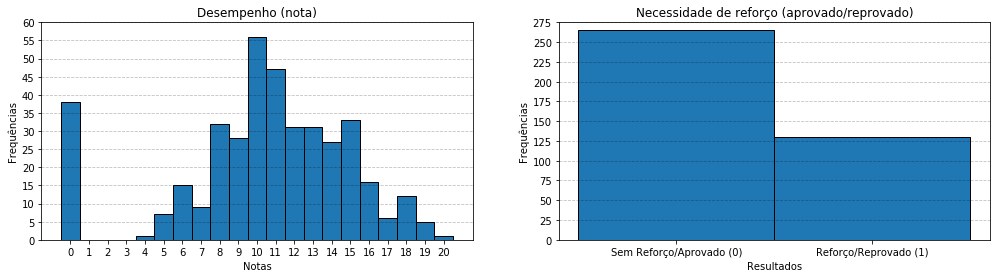

In [11]:
# Constrói os gráficos das tabelas de distribuição de frequência da célula anterior
plt.figure()
plt.subplot(1,2,1)
fig = Y.G3.plot.hist(bins=range(22), edgecolor='k', grid=False, figsize=(17,4))
fig.set_ylim(0,60)
fig.set_yticks(np.arange(0, 65, 5))
plt.grid(b=True, axis='y', color='k', linestyle='--', alpha=0.25)
plt.xlabel('Notas')
plt.ylabel('Frequências')
plt.title('Desempenho (nota)')
plt.xticks(np.arange(0.5, 21.5, 1), range(21))

plt.subplot(1,2,2)
fig = Yb.plot.hist(bins=2, edgecolor='k')
fig.set_ylim(0,275)
fig.set_yticks(np.arange(0, 300, 25))
plt.grid(b=True, axis='y', color='k', linestyle='--', alpha=0.25)
plt.xlabel('Resultados')
plt.ylabel('Frequências')
plt.title('Necessidade de reforço (aprovado/reprovado)')
plt.xticks([0.25, 0.75], ['Sem Reforço/Aprovado (0)', 'Reforço/Reprovado (1)'])
pass

#### Conclusões sobre o alvo (Y):
* Excluindo as notas 0, a distribuição de G3 é aproximadamente normal;
* Observam-se muitas notas 0 (38 ocorrências, 3ª nota mais frequente), provavelmente desistentes - entretanto, não se sabem as causas das desistências: mudança de escola, mudança de cidade, desistência de ensino, problema de saúde, falecimento etc;
* A nota mínima para aprovação (10) é a mais frequente (56 ocorrências), seguida pela nota 11 (47 ocorrências) - provavelmente muitos desses alunos foram "empurrados" pelo professor ou passaram no limite, sendo tais possibilidades possíveis de ser exploradas em outros trabalhos;
* A quantidade de alunos aprovados é o dobro da quantidade de alunos reprovados - tal desbalanceamente torna a acurácia uma medida praticamente inútil, pois pode-se obter uma acurácia de 0.67 simplesmentae classificando todos os alunos como "Não Reforço"/Aprovados.

****
### Etapa 3: Funções de suporte
Codificação de funções que serão usadas ao longo do trabalho:

#### Etapa 3a: Métricas
Função __metricas_binario( y_test, y_pred, verbose )__:
* Compara __y_test__ ao __y_pred__, determinando:
    * Matriz de Confusão
    * Acurácia
    * Precisão, Revocação e $F_{\beta}$-score com $\beta$ = 0,5 (ou $F_{0,5}$)
* Retorna vetor contendo:
    * Acurácia
    * $F_{0,5}$
* Se __verbose__, então imprime os resultados obtidos.

#### Etapa 3b: Pipeline
Função __model_pipeline( X, y, model )__:
* Recebe um dataset como entrada __(X, y)__ e o divide em subconjuntos de treino e de testes, com 20% para testes;
* Recebe um objeto __model__ do modelo de previsão como entrada e usa seu método __.fit__ com o subconjunto de treino;
* Usa o método __.predict__ do modelo para determinar os valores previstos de saída __(y_pred)__;
* Chama a função __metricas_binario( )__ para avaliar as previsões y_pred em comparação ao alvo y_test, e retorna acurácia e F0,5-score

In [12]:
#Funções de Suporte

def metricas_binario(y_test, y_pred, verbose=True):
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    scores = precision_recall_fscore_support(y_test, y_pred, beta=0.5, warn_for=())
    
    if verbose:
        print('Matriz de Confusão\n', cm[0], '\n', cm[1], '\n')
    
        print('Acurácia  = {:.3f}'.format(acc))
        print('Precisão  = {:.3f}'.format(scores[0][1]))
        print('Revocação = {:.3f}'.format(scores[1][1]))
        print('F0,5 scr  = {:.3f}'.format(scores[2][1]))
    
    return [acc, scores[2][1]]

def model_pipeline(X, Y, model, verbose=False):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    metricas = metricas_binario(y_test, y_pred, verbose)
    
    return metricas

****
### Etapa 4: Comparação acurácia e F0,5 para diferentes modelos de classificação
Esta etapa tem como objetivo determinar e comparar a acurácia e o F0,5 de alguns modelos de classificação usando como alvo o desempenho final dos estudantaes (aprovado=0/reprovado=1). Os passos desta etapa são:
* Criar um Data Frame chamado __metrics__ para armazenar as métricas (acurácia e F0,5-score) de cada técnica, bem como seu tempo médio para treino e previsão;
* Aplicar diversos modelos e gravar seus resultados em __metrics__:
    * Calcula a média da acurácia e do F0,5-score para 1000 previsões de cada técnica;
    * Mede o tempo de treino e previsão;
    * Grava e imprime as médias;
    * Calcula um modelo usando __verbose__ para imprimir matriz de confusão, precisão e revocação, como exemplo (apenas para algumas das técnicas).
* Exibir os resultados em uma tabela e em um gráfico;
* Analisar os resultados e tirar conclusões.

In [13]:
# Data Frame para armazenar as métricas
metrics = pd.DataFrame(columns = ['Acurácia', 'F0,5', 'Tempo'])

#### Etapa 4a: Previsor ingênuo (prevê que todos serão aprovados)
* Cria a classe __Previsor_ingenuo_aprova__ com os seguintes métodos:
    * __fit(X, y):__ não faz nada (precisa existir por causa da função __model_pipeline( )__ );
    * __predict(x):__ prevê 0 (aprovado, não precisa de reforço) para toda instância em x.
* Mede acurácia e F0,5 para tal modelo.

In [14]:
# CLASSE Previsor Ingênuo (prevê apenas aprovados)
class Previsor_ingenuo_aprova:
    def fit(self, X, y):
        pass
        
    def predict(self, X):
        return pd.DataFrame([0 for x in range(X.shape[0])]).iloc[:,0]

In [15]:
# Cálculo e exibição das métricas para o modelo Previsor Ingênuo (prevê apenas aprovados)
ac = 0
f1 = 0

# Cálculo das métricas
n = 1000
start = time()
for i in range(n): 
    nvamodel = Previsor_ingenuo_aprova()
    res = model_pipeline(X, Yb, nvamodel)
    ac += res[0]
    f1 += res[1]
dt = time() - start

# Média das métricas, grava no Data Frame metrics
metrics.loc[nvamodel.__class__.__name__] = [round(ac/n, 3), round(f1/n, 3), round(dt/n, 3)]

# Imprime as médias
print(formating.bold + 'Modelo: ' + nvamodel.__class__.__name__ + formating.resetbold)
print('Acurácia média = {:.3f}'.format(ac/n))
print('F0,5 scr médio = {:.3f}'.format(f1/n))

# Exibe um exemplo
print(formating.bold + '\nExemplo:' + formating.resetbold)
nvamodel = Previsor_ingenuo_aprova()
f1 = model_pipeline(X, Yb, nvamodel, True)

Modelo: Previsor_ingenuo_aprova
Acurácia média = 0.673
F0,5 scr médio = 0.000

Exemplo:
Matriz de Confusão
 [52  0] 
 [27  0] 

Acurácia  = 0.658
Precisão  = 0.000
Revocação = 0.000
F0,5 scr  = 0.000


#### Etapa 4b: Previsor ingênuo (prevê que todos serão reprovados)
* Cria a classe __Previsor_ingenuo_reprova__ com os seguintes métodos:
    * __fit(X, y):__ não faz nada (precisa existir por causa da função __model_pipeline( )__ );
    * __predict(x):__ prevê 1 (reprovado, precisa de reforço) para toda instância em x.
* Mede acurácia e F0,5 para tal modelo.

In [16]:
# CLASSE Previsor Ingênuo (prevê apenas reprovados)
class Previsor_ingenuo_reprova:
    def fit(self, X, y):
        pass
        
    def predict(self, X):
        return pd.DataFrame([1 for x in range(X.shape[0])]).iloc[:,0]

In [17]:
# Cálculo e exibição das métricas para o modelo Previsor Ingênuo (prevê apenas reprovados)
ac = 0
f1 = 0

# Cálculo das métricas
n = 1000
start = time()
for i in range(n): 
    nvrmodel = Previsor_ingenuo_reprova()
    res = model_pipeline(X, Yb, nvrmodel)
    ac += res[0]
    f1 += res[1]
dt = time() - start
    
# Média das métricas, grava no Data Frame metrics
metrics.loc[nvrmodel.__class__.__name__] = [round(ac/n, 3), round(f1/n, 3), round(dt/n, 3)]

# Imprime as médias
print(formating.bold + 'Modelo: ' + nvrmodel.__class__.__name__ + formating.resetbold)
print('Acurácia média = {:.3f}'.format(ac/n))
print('F0,5 scr médio = {:.3f}'.format(f1/n))

# Exibe um exemplo
print(formating.bold +'\nExemplo:' + formating.resetbold)
nvrmodel = Previsor_ingenuo_reprova()
f1 = model_pipeline(X, Yb, nvrmodel, True)

Modelo: Previsor_ingenuo_reprova
Acurácia média = 0.330
F0,5 scr médio = 0.380

Exemplo:
Matriz de Confusão
 [ 0 54] 
 [ 0 25] 

Acurácia  = 0.316
Precisão  = 0.316
Revocação = 1.000
F0,5 scr  = 0.367


#### Etapa 4c: Classificação via Regressão Logística
* Utiliza a classe __LogisticRegression__ do _scikitlearn_ para classificação binária;
* Mede acurácia e F0,5 para tal técnica.

In [18]:
# Cálculo e exibição das métricas para o modelo Regressão Logística
ac = 0
f1 = 0

# Cálculo das métricas
n = 1000
start = time()
for i in range(n): 
    logmodel = LogisticRegression()
    res = model_pipeline(X, Yb, logmodel)
    ac += res[0]
    f1 += res[1]
dt = time() - start

# Média das métricas, grava no Data Frame metrics
metrics.loc[logmodel.__class__.__name__] = [round(ac/n, 3), round(f1/n, 3), round(dt/n, 3)]

# Imprime as médias
print(formating.bold + 'Modelo: ' + logmodel.__class__.__name__ + formating.resetbold)
print('Acurácia média = {:.3f}'.format(ac/n))
print('F0,5 scr médio = {:.3f}'.format(f1/n))

# Exibe um exemplo
print(formating.bold + '\nExemplo:' + formating.resetbold)
logmodel = LogisticRegression()
f1 = model_pipeline(X, Yb, logmodel, True)

Modelo: LogisticRegression
Acurácia média = 0.684
F0,5 scr médio = 0.460

Exemplo:
Matriz de Confusão
 [45  7] 
 [21  6] 

Acurácia  = 0.646
Precisão  = 0.462
Revocação = 0.222
F0,5 scr  = 0.380


#### Etapa 4d: Classificação via k-Vizinhos Mais Próximos
* Utiliza a classe __KNeighborsClassifier__ do _scikitlearn_ para classificação binária;
* Mede acurácia e F0,5 para tal técnica.

In [19]:
# Cálculo e exibição das métricas para o modelo kNN (k-Vizinhos Mais Próximos)
ac = 0
f1 = 0

# Cálculo das métricas
n = 1000
start = time()
for i in range(n): 
    knnmodel = KNeighborsClassifier(n_neighbors=3)
    res = model_pipeline(X, Yb, knnmodel)
    ac += res[0]
    f1 += res[1]
dt = time() - start

# Média das métricas, grava no Data Frame metrics
metrics.loc[knnmodel.__class__.__name__] = [round(ac/n, 3), round(f1/n, 3), round(dt/n, 3)]

# Imprime as médias
print(formating.bold + 'Modelo: ' + knnmodel.__class__.__name__ + formating.resetbold)
print('Acurácia média = {:.3f}'.format(ac/n))
print('F0,5 scr médio = {:.3f}'.format(f1/n))

# Exibe um exemplo
print(formating.bold + '\nExemplo:' + formating.resetbold)
knnmodel = KNeighborsClassifier(n_neighbors=3)
f1 = model_pipeline(X, Yb, knnmodel, True)

Modelo: KNeighborsClassifier
Acurácia média = 0.599
F0,5 scr médio = 0.325

Exemplo:
Matriz de Confusão
 [43 12] 
 [18  6] 

Acurácia  = 0.620
Precisão  = 0.333
Revocação = 0.250
F0,5 scr  = 0.312


#### Etapa 4e: Classificação via Máquinas de Suporte de Vetores
* Utiliza a classe __SVC__ do _scikitlearn_ para classificação binária;
* Mede acurácia e F0,5 para tal técnica.

In [20]:
# Cálculo e exibição das métricas para o modelo SVC (Máquinas de Suporte de Vetores)
ac = 0
f1 = 0

# Cálculo das métricas
n = 1000
start = time()
for i in range(n): 
    svcmodel = SVC(kernel='linear', C=100)
    res = model_pipeline(X, Yb, svcmodel)
    ac += res[0]
    f1 += res[1]
dt = time() - start

# Média das métricas, grava no Data Frame metrics
metrics.loc[svcmodel.__class__.__name__] = [round(ac/n, 3), round(f1/n, 3), round(dt/n, 3)]

# Imprime as médias
print(formating.bold + 'Modelo: ' + svcmodel.__class__.__name__ + formating.resetbold)
print('Acurácia média = {:.3f}'.format(ac/n))
print('F0,5 scr médio = {:.3f}'.format(f1/n))

# Exibe um exemplo
print(formating.bold + '\nExemplo:' + formating.resetbold)
svcmodel = SVC(kernel='linear', C=100)
f1 = model_pipeline(X, Yb, svcmodel, True)

Modelo: SVC
Acurácia média = 0.680
F0,5 scr médio = 0.471

Exemplo:
Matriz de Confusão
 [49  8] 
 [12 10] 

Acurácia  = 0.747
Precisão  = 0.556
Revocação = 0.455
F0,5 scr  = 0.532


#### Etapa 4f: Classificação via Naïve Bayes Gaussiano
* Utiliza a classe __GaussianNB__ do _scikitlearn_ para classificação binária;
* Mede acurácia e F0,5 para tal técnica.

In [21]:
# Cálculo e exibição das métricas para o modelo Naïve Bayes Gaussiano
ac = 0
f1 = 0

# Cálculo das métricas
n = 1000
start = time()
for i in range(n): 
    gnbmodel = GaussianNB()
    res = model_pipeline(X, Yb, gnbmodel)
    ac += res[0]
    f1 += res[1]
dt = time() - start

# Média das métricas, grava no Data Frame metrics
metrics.loc[gnbmodel.__class__.__name__] = [round(ac/n, 3), round(f1/n, 3), round(dt/n, 3)]

# Imprime as médias
print(formating.bold + 'Modelo: ' + gnbmodel.__class__.__name__ + formating.resetbold)
print('Acurácia média = {:.3f}'.format(ac/n))
print('F0,5 scr médio = {:.3f}'.format(f1/n))

# Exibe um exemplo
print(formating.bold + '\nExemplo:' + formating.resetbold)
gnbmodel = GaussianNB()
f1 = model_pipeline(X, Yb, gnbmodel, True)

Modelo: GaussianNB
Acurácia média = 0.659
F0,5 scr médio = 0.459

Exemplo:
Matriz de Confusão
 [44 12] 
 [16  7] 

Acurácia  = 0.646
Precisão  = 0.368
Revocação = 0.304
F0,5 scr  = 0.354


#### Etapa 4g: Classificação via AdaBoost
* Utiliza a classe __AdaBoostClassifier__ do _scikitlearn_ para classificação binária;
* Mede acurácia e F0,5 para tal técnica.

In [22]:
# Cálculo e exibição das métricas para o modelo de Regressão por AdaBoost
ac = 0
f1 = 0

# Cálculo das métricas
n = 1000
start = time()
for i in range(n): 
    abcmodel = AdaBoostClassifier()
    res = model_pipeline(X, Yb, abcmodel)
    ac += res[0]
    f1 += res[1]
dt = time() - start

# Média das métricas, grava no Data Frame metrics
metrics.loc[abcmodel.__class__.__name__] = [round(ac/n, 3), round(f1/n, 3), round(dt/n, 3)]

# Imprime as médias
print(formating.bold + 'Modelo: ' + abcmodel.__class__.__name__ + formating.resetbold)
print('Acurácia média = {:.3f}'.format(ac/n))
print('F0,5 scr médio = {:.3f}'.format(f1/n))

# Exibe um exemplo
print(formating.bold + '\nExemplo:' + formating.resetbold)
abcmodel = AdaBoostClassifier()
f1 = model_pipeline(X, Yb, abcmodel, True)

Modelo: AdaBoostClassifier
Acurácia média = 0.664
F0,5 scr médio = 0.446

Exemplo:
Matriz de Confusão
 [46  7] 
 [20  6] 

Acurácia  = 0.658
Precisão  = 0.462
Revocação = 0.231
F0,5 scr  = 0.385


#### Etapa 4h: Classificação via Árvores de Decisão
* Utiliza a classe __DecisionTreeClassifier__ do _scikitlearn_ para classificação binária;
* Mede acurácia e F0,5 para tal técnica.

In [23]:
# Cálculo e exibição das métricas para o modelo Árvores de Decisão (DecisionTreeClassifier)
ac = 0
f1 = 0

# Cálculo das métricas
n = 1000
start = time()
for i in range(n): 
    dtcmodel = DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=3)
    res = model_pipeline(X, Yb, dtcmodel)
    ac += res[0]
    f1 += res[1]
dt = time() - start

# Média das métricas, grava no Data Frame metrics
metrics.loc[dtcmodel.__class__.__name__] = [round(ac/n, 3), round(f1/n, 3), round(dt/n, 3)]

# Imprime as médias
print(formating.bold + 'Modelo: ' + dtcmodel.__class__.__name__ + formating.resetbold)
print('Acurácia média = {:.3f}'.format(ac/n))
print('F0,5 scr médio = {:.3f}'.format(f1/n))

# Exibe um exemplo
print(formating.bold + '\nExemplo:' + formating.resetbold)
dtcmodel = DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=3)
f1 = model_pipeline(X, Yb, dtcmodel, True)

Modelo: DecisionTreeClassifier
Acurácia média = 0.614
F0,5 scr médio = 0.409

Exemplo:
Matriz de Confusão
 [40 15] 
 [12 12] 

Acurácia  = 0.658
Precisão  = 0.444
Revocação = 0.500
F0,5 scr  = 0.455


#### Resumo dos Resultados de acurácia e F0,5 para diferentes técnicas de classificação:
Será usado o Data Frame __metrics__ para criar:
* Tabela com acurácia, F0,5 e tempo de treino e previsão para cada técnica testada;
* Respectivo Gráfico de barras.

                          Acurácia   F0,5  Tempo
Previsor_ingenuo_aprova      0.673  0.000  0.003
Previsor_ingenuo_reprova     0.330  0.380  0.003
LogisticRegression           0.684  0.460  0.005
KNeighborsClassifier         0.599  0.325  0.007
SVC                          0.680  0.471  0.540
GaussianNB                   0.659  0.459  0.004
AdaBoostClassifier           0.664  0.446  0.087
DecisionTreeClassifier       0.614  0.409  0.005


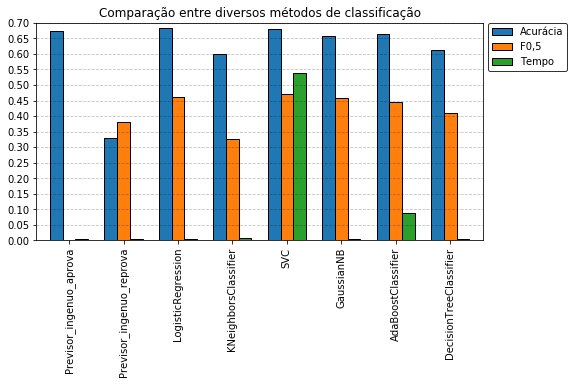

In [24]:
# Impressão da tabela com os resultados:
print(metrics)

# Impressão do gráfico com os resultados:
fig = metrics.plot.bar(figsize=(8,4), width=0.7, edgecolor='k')
fig.grid(b=True, axis='y', color='k', linestyle='--', alpha=0.25)
fig.set_ylim(0,0.6)
fig.set_yticks(np.arange(0, 0.75, 0.05))
plt.title('Comparação entre diversos métodos de classificação')
plt.legend(loc='lower left', bbox_to_anchor=(1, .755), edgecolor='k')
pass

#### Conclusões sobre acurácia e F0,5 para diferentes modelos de classificação:
* Em termos de acurácia, apenas a Regressão Logística e a Máquina de Suporte de Vetor conseguiram superar um modelo que simplesmente prevê que nenhum aluno precisa de reforço. Os modelos Naïve Bayes e AdaBoost obtiveram resultados quase tão bons quanto os dois primeiros. Na verdade, os quatro modelos foram os únicos com acurácia acima de 0,65, contra uma acurácia de 0,67 do previsor ingênuo de aprovação.
* Os quatro modelos citados anateriormente também tiveram os maiores F0,5 Scores, obtendo pelo menos 0,445, contra um F0,5-Score de 0,38 do previsor ingênuo de reprovação. Deve-se lembrar que dar reforço a todos os alunos evita que alunos que seriam reprovados fiquem sem reforço, mas desperdiça muitos recursos com alunos que seriam aprovados sem reforço. Talvez por este motivo, praticamente qualquer modelo (exceto kNN) consegue superá-lo facilmente.
* O tempo de execução da Máquina de Suporte de Vetor (SVC) é muito maior do que os demais, mas seu desempenho é bastante similar ao da Regressão Logística. Dessa forma, tal modelo não será usado.
* __Conclusão:__ Entre os modelos testados, os mais promissores são: Regressão Logística, Naïve Bayes e AdaBoost.

****
### Etapa 5: Seleção de atributos
Nesta etapa, serão estudadas as importâncias de cada atributo para a previsão da necessidade de reforço. Em seguida, os modelos serão testados novamente apenas com atributos mais importantes e as novas métricas serão comparadas com as antigas. Etapas:
* Treinar 250 modelos de cada técnica de classificação;
    * __Regressão Logística:__ técnica com um dos melhores resultados obtidos na etapa anterior. Serão usados seus coeficientes para tentar determinar os atributos mais importantes;
    * __AdaBoost:__ técnica com bons resultados obtidos na etapa anterior. Serão usadas suas importâncias dos atributos para tentar determinar os atributos mais importantes;
    * __Árvores de Decisão:__ tal técnica obteve resultados relativamente fracos na etapa anterior. Entretanto, serão usadas suas importâncias dos atributos para tentar conseguir insights sobre os atributos mas importantes;
    * __Naive Bayes:__ apesar de apresentar bons resultados na etapa anterior, o modelo não possui coeficientes ou importâncias dos atributos que ajudem a determinar os atributos mais importantes;
* Tirar a média dos coeficientes ou das importâncias dos atributos de cada técnica;
* Exibir tabela com os maiores coeficientes ou as maiores importâncias dos atributos de cada técnica;
* Exibir gráfico dos coeficientes ou das importâncias dos atributos de cada técnica;
* Escolher os atributos mais importantes.

Modelo: LogisticRegression
failures         1.921767
goout            1.412227
age              0.968622
higher          -0.735950
schoolsup        0.729650
famrel          -0.524367
studytime       -0.508914
famsup           0.507590
Mjob_teacher     0.506225
sex             -0.464628
Mjob_health     -0.445216
Fjob_teacher    -0.434227
Mjob_services   -0.403221
Name: coef, dtype: float64 



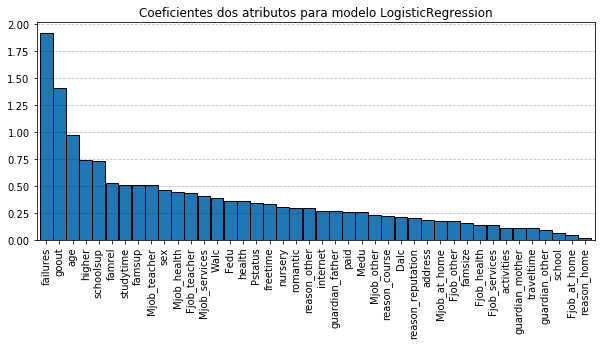

In [25]:
# Seleção de Atributos - Regressão Logística
logcoefs = np.zeros(X.columns.shape[0])

# Cálculo dos coeficientes
n = 250
for i in range(n): 
    logmodel = LogisticRegression()
    X_train, X_test, y_train, y_test = train_test_split(X, Yb, test_size=0.2)
    logmodel.fit(X_train, y_train)
    logcoefs += np.array(logmodel.coef_[0])

# Média dos coeficientes, grava em um Data Frame
logcoefs /= n
logmodel_coefs = pd.DataFrame(data={'coef': logcoefs, 'abscoef':abs(logcoefs)}, 
                              index=X.columns).sort_values(by='abscoef', ascending=False)

# Imprime os maiores coeficientes
print(formating.bold + 'Modelo: ' + logmodel.__class__.__name__ + formating.resetbold)
print(logmodel_coefs[logmodel_coefs.abscoef > 0.4].coef, '\n')

# Gráfico de todos os coeficientes
logmodel_coefs.drop(['coef'], 1).plot.bar(figsize=(10,4), legend=False, 
                                          width=0.975, edgecolor='k')
plt.grid(b=True, axis='y', color='k', linestyle='--', alpha=0.25)
plt.title('Coeficientes dos atributos para modelo ' + logmodel.__class__.__name__)
pass

Modelo: AdaBoostClassifier
           feat_imp
failures    0.09600
age         0.07992
freetime    0.07168
goout       0.06496
Dalc        0.04728
studytime   0.04528
Walc        0.04168
Fedu        0.04104
famrel      0.04096
health      0.03864


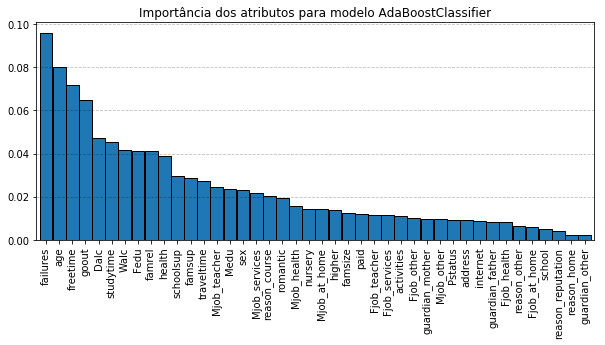

In [26]:
# Seleção de Atributos - AdaBoostClassifier
abccoefs = np.zeros(X.columns.shape[0])

# Cálculo dos feature importances
n = 250
for i in range(n): 
    abcmodel = AdaBoostClassifier()
    X_train, X_test, y_train, y_test = train_test_split(X, Yb, test_size=0.2)
    abcmodel.fit(X_train, y_train)
    abccoefs += np.array(abcmodel.feature_importances_)

# Média dos feature importances, grava em um Data Frame
abccoefs /= n
abcmodel_coefs = pd.DataFrame(data=abccoefs, columns=['feat_imp'], 
                              index=X.columns).sort_values(by='feat_imp', ascending=False)

# Imprime os maiores feature importances
print(formating.bold + 'Modelo: ' + abcmodel.__class__.__name__ + formating.resetbold)
print(abcmodel_coefs.iloc[:10].sort_values(by='feat_imp', ascending=False))

# Gráfico de todos os feature importances
abcmodel_coefs.plot.bar(figsize=(10,4), legend=False, width=0.975, edgecolor='k')
plt.grid(b=True, axis='y', color='k', linestyle='--', alpha=0.25)
plt.title('Importância dos atributos para modelo ' + abcmodel.__class__.__name__)
pass

Modelo: DecisionTreeClassifier
           feat_imp
failures   0.167143
freetime   0.062720
health     0.054655
goout      0.053166
Walc       0.047469
studytime  0.047144
Fedu       0.046010
age        0.040355
famrel     0.036876
Medu       0.034896


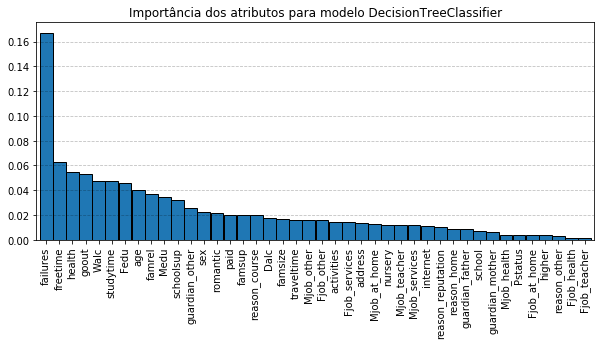

In [27]:
# Seleção de Atributos - DecisionTreeClassifier
dtccoefs = np.zeros(X.columns.shape[0])

# Cálculo dos feature importances
n = 250
for i in range(n): 
    dtcmodel = DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=3)
    X_train, X_test, y_train, y_test = train_test_split(X, Yb, test_size=0.2)
    dtcmodel.fit(X_train, y_train)
    dtccoefs += np.array(dtcmodel.feature_importances_)

# Média dos feature importances, grava em um Data Frame
dtccoefs /= n
dtcmodel_coefs = pd.DataFrame(data=dtccoefs, columns=['feat_imp'], 
                              index=X.columns).sort_values(by='feat_imp', ascending=False)

# Imprime os maiores feature importances
print(formating.bold + 'Modelo: ' + dtcmodel.__class__.__name__ + formating.resetbold)
print(dtcmodel_coefs.iloc[:10].sort_values(by='feat_imp', ascending=False))

# Gráfico de todos os feature importances
dtcmodel_coefs.plot.bar(figsize=(10,4), legend=False, width=0.975, edgecolor='k')
plt.grid(b=True, axis='y', color='k', linestyle='--', alpha=0.25)
plt.title('Importância dos atributos para modelo ' + dtcmodel.__class__.__name__)
pass

#### Conclusões
* O atributo __schoolsup__ denota se o aluno já recebe algum suporte extra da escola e impacta positivamente sobre a necessidade de reforço. Em outra palavras, se o aluno recebe suporte extra, então é mais provável que ele acabe sendo reprovado. Isto pode significar que apenas alunos com dificuldades recebem tal suporte. Entretanto, as condições nas quais os alunos são selecionados para tal suporte não estão claras e podem ser subjetivas. Por este motivo, este atributo será __excluído__ dos modelos de previsão;
* O atributo __sex__ tem o 10º maior coeficiente da Regressão Logística, mas tem importância bem menor nos demais modelos. Por este motivo, ele também será __excluído__ dos modelos de previsão;
* Os 10 atributos com maiores coeficientes da Regressão Logística, exceto os dois anteriores (schoolsup e sex) serão mantidos: failures, goout, age, higher, studytime, famsup, Mjob_teacher, famrel;
* Os atributos __freetime__ e __health__ estão entre os mais importantes dos modelos AdaBoost e DecisionTree e, portanto, serão mantidos;
* O atributo __Dalc__ é o quinto mais importante do AbaBoost e também será __mantido__;
* Todos os demais atributos serão excluídos.

****
### Etapa 6: Comparação acurácia e F0,5 para atributos selecionados
A Etapa 4 será repetida para as técnicas de classificação com melhores resultados, e apenas com os atributos selecionados na Etapa 5.
* Criar variável __X2__ com os atributos selecionados;
* Criar um Data Frame chamado __metrics2__ para armazenar as métricas (acurácia e F0,5-score) de cada técnica;
* Aplicar diversos modelos e gravar seus resultados em __metrics2__:
    * Calcula a média da acurácia e do F0,5-score para 1000 previsões de cada técnica;
    * Grava e imprime as médias;
    * Calcula um modelo usando __verbose__ para imprimir matriz de confusão, precisão e revocação, como exemplo.
* Exibir os resultados em uma tabela e em um gráfico;
* Analisar os resultados e tirar conclusões.

In [28]:
# Atributos selecionados
X2 = X[['failures', 'goout', 'age', 'higher', 'studytime', 'famsup', 'Mjob_teacher', 'famrel', 
        'freetime', 'health','Dalc']]

# Data Frame para armazenar as métricas
metrics2 = pd.DataFrame(columns = ['Acurácia', 'F0,5-score'])

#### Etapa 6a: Classificação via Regressão Logística
* Utiliza a classe __LogisticRegression__ do _scikitlearn_ para classificação binária;
* Mede acurácia e F0,5 para tal técnica.

In [29]:
# Cálculo e exibição das métricas para o modelo Regressão Logística
ac = 0
f1 = 0

# Cálculo das métricas
n = 1000
for i in range(n): 
    logmodel2 = LogisticRegression()
    res = model_pipeline(X2, Yb, logmodel2)
    ac += res[0]
    f1 += res[1]

# Média das métricas, grava no Data Frame metrics2
metrics2.loc[logmodel2.__class__.__name__] = [round(ac/n, 3), round(f1/n, 3)]

# Imprime as médias
print(formating.bold + 'Modelo: ' + logmodel2.__class__.__name__ + formating.resetbold)
print('Acurácia média = {:.3f}'.format(ac/n))
print('F0,5 scr médio = {:.3f}'.format(f1/n))

# Exibe um exemplo
print(formating.bold + '\nExemplo:' + formating.resetbold)
logmodel2 = LogisticRegression()
f1 = model_pipeline(X2, Yb, logmodel2, True)

Modelo: LogisticRegression
Acurácia média = 0.733
F0,5 scr médio = 0.560

Exemplo:
Matriz de Confusão
 [55  1] 
 [15  8] 

Acurácia  = 0.797
Precisão  = 0.889
Revocação = 0.348
F0,5 scr  = 0.678


#### Etapa 6b: Classificação via Naïve Bayes
* Utiliza a classe __GaussianNB__ do _scikitlearn_ para classificação binária;
* Mede acurácia e F0,5 para tal técnica.

In [30]:
# Cálculo e exibição das métricas para o modelo GaussianNB
ac = 0
f1 = 0

# Cálculo das métricas
n = 1000
for i in range(n): 
    gnbmodel2 = GaussianNB()
    res = model_pipeline(X2, Yb, gnbmodel2)
    ac += res[0]
    f1 += res[1]

# Média das métricas, grava no Data Frame metrics2
metrics2.loc[gnbmodel2.__class__.__name__] = [round(ac/n, 3), round(f1/n, 3)]

# Imprime as médias
print(formating.bold + 'Modelo: ' + gnbmodel2.__class__.__name__ + formating.resetbold)
print('Acurácia média = {:.3f}'.format(ac/n))
print('F0,5 scr médio = {:.3f}'.format(f1/n))

# Exibe um exemplo
print(formating.bold + '\nExemplo:' + formating.resetbold)
gnbmodel2 = GaussianNB()
f1 = model_pipeline(X2, Yb, gnbmodel2, True)

Modelo: GaussianNB
Acurácia média = 0.712
F0,5 scr médio = 0.515

Exemplo:
Matriz de Confusão
 [45  3] 
 [23  8] 

Acurácia  = 0.671
Precisão  = 0.727
Revocação = 0.258
F0,5 scr  = 0.533


#### Etapa 6c: Classificação via AdaBoost
* Utiliza a classe __AdaBoostClassifier__ do _scikitlearn_ para classificação binária;
* Mede acurácia e F0,5 para tal técnica.

In [31]:
# Cálculo e exibição das métricas para o modelo AdaBoostClassifier
ac = 0
f1 = 0

# Cálculo das métricas
n = 1000
for i in range(n): 
    abcmodel2 = AdaBoostClassifier()
    res = model_pipeline(X2, Yb, abcmodel2)
    ac += res[0]
    f1 += res[1]

# Média das métricas, grava no Data Frame metrics2
metrics2.loc[abcmodel2.__class__.__name__] = [round(ac/n, 3), round(f1/n, 3)]

# Imprime as médias
print(formating.bold + 'Modelo: ' + abcmodel2.__class__.__name__ + formating.resetbold)
print('Acurácia média = {:.3f}'.format(ac/n))
print('F0,5 scr médio = {:.3f}'.format(f1/n))

# Exibe um exemplo
print(formating.bold + '\nExemplo:' + formating.resetbold)
abcmodel2 = AdaBoostClassifier()
f1 = model_pipeline(X2, Yb, abcmodel2, True)

Modelo: AdaBoostClassifier
Acurácia média = 0.677
F0,5 scr médio = 0.464

Exemplo:
Matriz de Confusão
 [40 10] 
 [17 12] 

Acurácia  = 0.658
Precisão  = 0.545
Revocação = 0.414
F0,5 scr  = 0.513


#### Resumo dos Resultados de acurácia e F0,5 para diferentes técnicas de classificação:
Será usado o Data Frame __metrics2__ para criar:
* Tabela com acurácia e F0,5-score para cada técnica testada;
* Respectivo Gráfico de barras.

                    Acurácia  F0,5-score
LogisticRegression     0.733       0.560
GaussianNB             0.712       0.515
AdaBoostClassifier     0.677       0.464


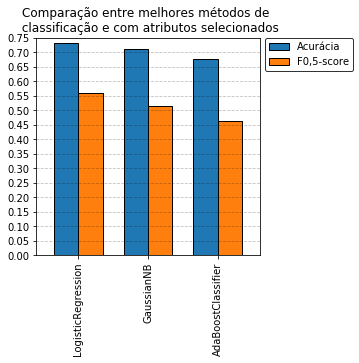

In [32]:
# Impressão da tabela com os resultados:
print(metrics2)

# Impressão do gráfico com os resultados:
fig = metrics2.plot.bar(grid=False, figsize=(4,4), width=0.7, edgecolor='k')
fig.grid(b=True, axis='y', color='k', linestyle='--', alpha=0.25)
fig.set_ylim(0,0.7)
fig.set_yticks(np.arange(0, 0.8, 0.05))
plt.title('Comparação entre melhores métodos de \n classificação e com atributos selecionados')
plt.legend(loc='lower left', bbox_to_anchor=(1, .825), edgecolor='k')
pass

#### Conclusões
* Ao se selecionar apenas os atributos mais importantes ('failures', 'goout', 'age', 'higher', 'studytime', 'famsup', 'Mjob_teacher', 'famrel', 'freetime', 'health' e 'Dalc'), os três melhores modelos de classificação determinados na etapa 4 (LogisticRegression, GaussianNB e AdaBoostClassifier) melhoraram significativamente seu desempenho. 
* A __Regressão Logística__ continua sendo a melhor técnica de modelagem, tendo sua acurácia elevada de 0,68 para 0,73 e seu F0,5-score aumentado de 0,46 para aproximadamente 0,56. Seu desempenho nestas condições é o melhor obtido neste trabalho.

****
### Etapa 7: Conclusões
* O melhor modelo para previsão é a Regressão Logística, com F0,5-Score de aproximadamente 0,56;
* O melhor conjunto de atributos é o que se segue:

In [33]:
# Lista com todos os atributos de X2 - atributos selecionados para ser usados no modelo
for i, x in enumerate(X2.columns):
    print('{:02d}) {:21s}'.format(i+1, x), end='')
    if (i-3)%4 == 0: print('')

01) failures             02) goout                03) age                  04) higher               
05) studytime            06) famsup               07) Mjob_teacher         08) famrel               
09) freetime             10) health               11) Dalc                 

### Treinamento do modelo final proposto para resolver o problema:

In [34]:
# Validação cruzada
X_train, X_test, y_train, y_test = train_test_split(X2, Yb, test_size=0.2, random_state=45)

# Treino
finalmodel = LogisticRegression()
finalmodel.fit(X_train, y_train)

# Previsões para subconjunto de testes
y_pred = finalmodel.predict(X_test)

# Imprime métricas do subconjunto de testes
print(formating.bold + 'Modelo Final: ' + finalmodel.__class__.__name__ + formating.resetbold)
print('Métricas para o subconjunto de testes:\n')
metricas_binario(y_test, y_pred, True)
pass

Modelo Final: LogisticRegression
Métricas para o subconjunto de testes:

Matriz de Confusão
 [47  4] 
 [19  9] 

Acurácia  = 0.709
Precisão  = 0.692
Revocação = 0.321
F0,5 scr  = 0.562


### Avaliação do Modelo sobre o dataset completo
Caso o modelo final proposto fosse aplicado sobre todo o _dataset_, os resultados obtidos seriam:

Modelo Final: LogisticRegression
Métricas para o dataset completo:

Matriz de Confusão
 [251  14] 
 [89 41] 

Acurácia  = 0.739
Precisão  = 0.745
Revocação = 0.315
F0,5 scr  = 0.586


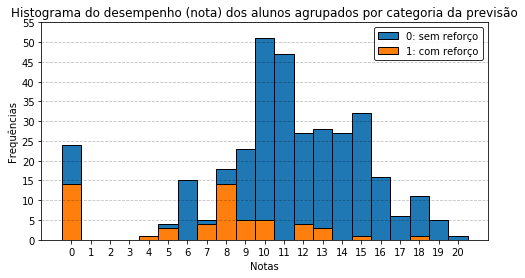

In [35]:
# Previsões para dataset completo
y_pred = finalmodel.predict(X2)

# Imprime métricas do dataset completo
print(formating.bold + 'Modelo Final: ' + finalmodel.__class__.__name__ + formating.resetbold)
print('Métricas para o dataset completo:\n')
metricas_binario(Yb, y_pred, True)

# Gráfico com histogramas das notas
plt.figure()
Y.G3[y_pred == 0].plot.hist(bins=range(22), edgecolor='k', figsize=(8,4), label='0: sem reforço')
Y.G3[y_pred == 1].plot.hist(bins=range(20), edgecolor='k', figsize=(8,4), label='1: com reforço')
plt.legend(edgecolor='k')
plt.grid(b=True, axis='y', color='k', linestyle='--', alpha=0.25)
plt.xlabel('Notas')
plt.ylabel('Frequências')
plt.title('Histograma do desempenho (nota) dos alunos agrupados por categoria da previsão')
plt.xticks(np.arange(0.5, 21.5, 1), range(21))
plt.yticks(range(0,60,5))
pass

__Observações Finais:__ 
1. Pode-se observar que boa parte dos alunos com nota abaixo de 10 foram identificados corretamente pelo modelo, enquanto que uma quantidade muito baixa de alunos com notas a partir de 10 foram classificados incorretamente.
2. Além disso, é notável como o modelo evita classificar os alunos como elegíveis para algum programa de reforço para tentar manter a precisão elevada e, consequentemente, o $F_{\beta = 0,5}-score$. Como alta precisão significa baixa quantidade Falsos Positivos, pode-se concluir que o modelo mais eficiente em termos de custos é aquele que prevê poucas necessidades de reforço.